In [1]:
import csv
import numpy as np
import pandas as pd

np.random.seed(0)

# Chargement du dataset existant
df = pd.read_csv('donnees_sante.csv')

# Calcul du nombre de records à supprimer
n_samples = len(df)
n_labels_to_remove = int(0.6 * n_samples)
n_labels_to_remove_normal = int(0.3 * n_labels_to_remove)
n_labels_to_remove_critical = n_labels_to_remove - n_labels_to_remove_normal

# Sélection aléatoire des indices des labels à supprimer de classe "Normal"
indices_normal = df[df['Class'] == 'Normal'].index
indices_to_remove_normal = np.random.choice(indices_normal, size=n_labels_to_remove_normal, replace=False)

# Sélection aléatoire des indices des labels à supprimer de classe "Critical"
indices_critical = df[df['Class'] == 'Critical'].index
indices_to_remove_critical = np.random.choice(indices_critical, size=n_labels_to_remove_critical, replace=False)

# Fusion des indices à supprimer
indices_to_remove = np.concatenate((indices_to_remove_normal, indices_to_remove_critical))

# Suppression des labels correspondants
df.loc[indices_to_remove, 'Class'] = ''

# Chemin du fichier CSV de sortie
output_file = 'nouveau_dataset.csv'

# Écriture du nouveau dataset dans un fichier CSV
df.to_csv(output_file, index=False)

# Affichage des données générées
print(df.to_string(index=False))

# Calcul du nombre de records avec labels
n_records_with_labels = df[df['Class'] != ''].shape[0]

# Calcul du nombre de records sans labels
n_records_without_labels = df[df['Class'] == ''].shape[0]

# Affichage du nombre de records avec labels et sans labels
print("Nombre de records avec labels : ", n_records_with_labels)
print("Nombre de records sans labels : ", n_records_without_labels)



 SP02  BP Systolic  BP Diastolic  HR  Pulse  Temperature    Class
   90          136            37 190     27         39.5         
   85          119            74  65     18         36.4   Normal
   86          116            71 100     12         37.0   Normal
   86          111            84 120     14         36.2         
   87          119            76  81     15         36.4         
   87          115            79  76     13         36.7   Normal
   85           25            30 173     24         39.4         
   88          112            84  67     13         36.8   Normal
   95           58            33 169     22         40.4 Critical
   89           24            65 198     26         39.1         
   88           94             8 177     26         39.3         
   86          120            76  98     19         37.2         
   87          114            82  84     19         36.4         
   95           83            94 182     21         39.8         
   94     

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Record 1 - Predicted Label: Critical
Record 2 - Predicted Label: Normal
Record 3 - Predicted Label: Normal
Record 4 - Predicted Label: Normal
Record 5 - Predicted Label: Normal
Record 6 - Predicted Label: Critical
Record 7 - Predicted Label: Critical
Record 8 - Predicted Label: Critical
Record 9 - Predicted Label: Normal
Record 10 - Predicted Label: Normal
Record 11 - Predicted Label: Critical
Record 12 - Predicted Label: Critical
Record 13 - Predicted Label: Critical
Record 14 - Predicted Label: Normal
Record 15 - Predicted Label: Critical
Record 16 - Predicted Label: Critical
Record 17 - Predicted Label: Critical
Record 18 - Predicted Label: Critical
Record 19 - Predicted Label: Critical
Record 20 - Predicted Label: Critical
Record 21 - Predicted Label: Normal
Record 22 - Predicted Label: Critical
Record 23 - Predicted Label: Critical
Record 24 - Predicted Label: Critical
Record 25 - Predicted Label: Critical
Record 26 - Predicted Label: Critical
Record 27 - Predicted Label: Critical

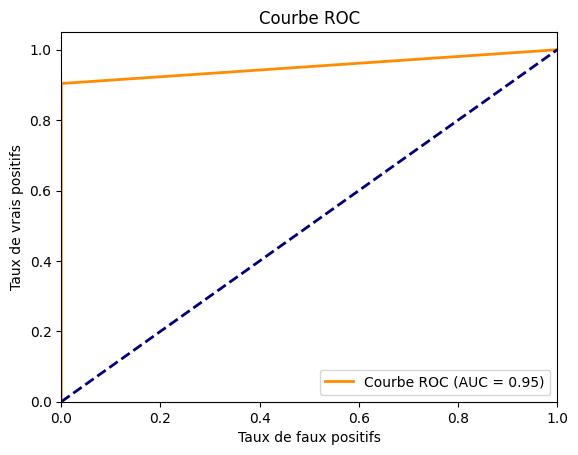

              precision    recall  f1-score   support

    Critical       0.91      1.00      0.95       125
      Normal       1.00      0.90      0.95       125

    accuracy                           0.95       250
   macro avg       0.96      0.95      0.95       250
weighted avg       0.96      0.95      0.95       250



In [3]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Chargement du dataset
dataset = pd.read_csv('nouveau_dataset.csv')

# Séparation des données et des classes
X_labeled = dataset[~dataset['Class'].isnull()].drop('Class', axis=1)
X_unlabeled = dataset[dataset['Class'].isnull()].drop('Class', axis=1)
y_labeled = dataset[~dataset['Class'].isnull()]['Class']

# Conversion des classes en valeurs numériques
label_map = {'Critical': 0, 'Normal': 1}
y_numeric = np.array([label_map[label] for label in y_labeled])

# Création du modèle de propagation de labels
model = LabelPropagation()

# Entraînement du modèle sur les données étiquetées
model.fit(X_labeled, y_numeric)

# Prédiction des classes pour les données non étiquetées
y_pred = model.predict(X_unlabeled)

# Remplacement des valeurs numériques par les étiquettes originales
y_pred_labels = np.array(['Critical' if label == 0 else 'Normal' for label in y_pred])

# Mise à jour du dataset avec les classes prédites
dataset.loc[dataset['Class'].isnull(), 'Class'] = y_pred_labels

# Affichage des prédictions de labels pour les données non étiquetées
for i, label in enumerate(y_pred_labels):
    print(f"Record {i+1} - Predicted Label: {label}")

# Chargement du dataset initial avec les classes réelles
dataset_initial = pd.read_csv('donnees_sante.csv')

# Extraction des classes réelles du dataset initial
y_true = dataset_initial['Class'].values

# Extraction des classes prédites du nouveau dataset
y_pred = dataset['Class'].values

# Conversion des étiquettes en valeurs binaires
y_true_binary = label_binarize(y_true, classes=['Critical', 'Normal'])
y_pred_binary = label_binarize(y_pred, classes=['Critical', 'Normal'])

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_true_binary.ravel(), y_pred_binary.ravel())
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Calcul des métriques de classification
classification_metrics = classification_report(y_true, y_pred)
print(classification_metrics)

# Sauvegarde du dataset mis à jour
dataset.to_csv('Predictions-semi-supervise.csv', index=False)


In [4]:
import pandas as pd

# Chargement des fichiers
dataset_original = pd.read_csv('donnees_sante.csv')
dataset_semi_supervise = pd.read_csv('nouveau_dataset.csv')
predictions_semi_supervise = pd.read_csv('Predictions-semi-supervise.csv')

# Division du fichier 'donnees_sante.csv' en train_initial et test_initial
train_initial = dataset_original.sample(frac=0.8, random_state=42)
test_initial = dataset_original.drop(train_initial.index)

train_semi_supervise = dataset_semi_supervise.sample(frac=0.8, random_state=42)
test_semi_supervise = dataset_semi_supervise.drop(train_initial.index)

train_predictions = predictions_semi_supervise.sample(frac=0.8, random_state=42)
test_predictions = predictions_semi_supervise.drop(train_predictions.index)

# Sauvegarde des fichiers train_initial.csv et test_initial.csv
train_initial.to_csv('train_initial.csv', index=False)
test_initial.to_csv('test_initial.csv', index=False)

train_semi_supervise.to_csv('train_semi_supervise.csv',index=False)
test_semi_supervise.to_csv('test_semi_supervise.csv',index=False)

# Sauvegarde du fichier train_predictions.csv
train_predictions.to_csv('train_predictions.csv', index=False)

# Suppression de la colonne 'classe' du fichier test_predictions
test_predictions_without_class = test_predictions.iloc[:, :-1]

# Sauvegarde du fichier test_predictions.csv sans la colonne 'classe'
test_predictions_without_class.to_csv('test_predictions.csv', index=False)

# Affichage du nombre de lignes de chaque fichier
print("Nombre de lignes dans train_initial.csv :", len(train_initial))
print("Nombre de lignes dans test_initial.csv :", len(test_initial))
print("Nombre de lignes dans train_predictions.csv :", len(train_predictions))
print("Nombre de lignes dans test_predictions.csv :", len(test_predictions_without_class))


Nombre de lignes dans train_initial.csv : 200
Nombre de lignes dans test_initial.csv : 50
Nombre de lignes dans train_predictions.csv : 200
Nombre de lignes dans test_predictions.csv : 50


In [6]:
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Chargement des données d'entraînement
train_data = pd.read_csv("train_predictions.csv")

# Séparation des features (X) et de la variable cible (y)
X_train = train_data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
y_train = train_data.iloc[:, -1]  # Dernière colonne

# Entraînement du modèle SARSA
sarsa_model = SGDClassifier(loss='log')
sarsa_model.fit(X_train, y_train)

# Chargement des données de test
test_data = pd.read_csv("test_semi_supervise.csv")
X_test = test_data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière

# Prédiction des classes pour les données de test
predicted_classes = sarsa_model.predict(X_test)

# Création d'un nouveau dataframe avec les prédictions
sarsa_predictions = pd.DataFrame({
    "Classe Prédite": predicted_classes
})

SARSA_vs_Label_propagation = pd.DataFrame({
    "Prédictions SARSA        |": predicted_classes
})

# Chargement des données réelles pour comparaison
actual_data = pd.read_csv("test_initial.csv")

# Extraction des classes réelles
y_actual = actual_data.iloc[:, -1]

#chargement des données prédites du semi-supervisé pour comparaison
Label_propagation_data=pd.read_csv("test_predictions.csv")

#Extraction des données prédites de Label Propagation
y_semi = Label_propagation_data.iloc[:, -1]

# Ajout de la colonne des classes réelles dans le dataframe des prédictions
sarsa_predictions["Classe Réelle"] = y_actual

# Ajout de la colonne des classes prédites par Label Propagation
SARSA_vs_Label_propagation["Prédictions Label Propagation"] = y_semi

# Affichage des classes prédites et réelles côte à côte
print(sarsa_predictions)

# Encodage des classes réelles en valeurs numériques catégorielles
label_encoder = LabelEncoder()
y_actual_encoded = label_encoder.fit_transform(y_actual)
y_predicted_encoded = label_encoder.transform(predicted_classes)

# Calcul de la précision
accuracy = accuracy_score(y_actual_encoded, y_predicted_encoded)
print("Précision : ", accuracy)

# Calcul du rappel
recall = recall_score(y_actual_encoded, y_predicted_encoded, average='macro')
print("Rappel : ", recall)

# Calcul du score F1
f1 = f1_score(y_actual_encoded, y_predicted_encoded, average='macro')
print("Score F1 : ", f1)

# Calcul du taux d'erreur
error_rate = 1 - accuracy
print("Taux d'erreur : ", error_rate)

# Calcul de la courbe ROC (stratégie "ovo")
roc_auc = roc_auc_score(y_actual_encoded, sarsa_model.decision_function(X_test), multi_class='ovo')
print("Courbe ROC : ", roc_auc)



   Classe Prédite Classe Réelle
0          Normal        Normal
1        Critical      Critical
2        Critical      Critical
3        Critical      Critical
4          Normal        Normal
5          Normal        Normal
6        Critical      Critical
7          Normal        Normal
8        Critical      Critical
9          Normal        Normal
10         Normal        Normal
11         Normal        Normal
12       Critical      Critical
13       Critical      Critical
14         Normal        Normal
15         Normal        Normal
16       Critical      Critical
17       Critical      Critical
18       Critical      Critical
19         Normal        Normal
20       Critical      Critical
21       Critical      Critical
22       Critical      Critical
23       Critical      Critical
24         Normal        Normal
25         Normal        Normal
26         Normal        Normal
27       Critical      Critical
28       Critical      Critical
29         Normal        Normal
30      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
